<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/Cabbage_predict_0707.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# data = pd.read_excel("Cabbage.xlsx")
data = pd.read_excel("/content/drive/MyDrive/市場批發交易歷史資料/Cabbage.xlsx")

In [5]:
data = data.dropna()
data = data.loc[data["Market"] == "台北一"]
np.array(data["Avg_price"]).reshape(-1,1)

array([[ 8.9],
       [ 7.2],
       [ 6.7],
       ...,
       [15.1],
       [15.1],
       [15.5]])

In [6]:
data_train = data[data["Date"] < "2019-01-01"]
data_test = data[data["Date"] >= "2019-01-01"]

In [7]:
data_train = data_train.drop(["Date", "Market", "Product", "Month", "Week_day", "Year", "Rest_day"], axis=1)
data_train

,Up_price,Mid_price,Low_price,Avg_price,Volume
39204,11.0,8.0,5.0,8.9,192029.0
39205,9.0,7.0,4.0,7.2,174270.0
39206,8.0,6.0,3.0,6.7,125426.0
39207,10.0,7.0,4.0,7.1,119318.0
39208,9.0,7.0,5.0,6.8,118178.0
...,...,...,...,...,...
46137,10.5,5.9,2.5,6.1,170578.0
46138,9.4,5.8,2.7,5.9,170145.0
46139,9.6,5.2,2.8,5.6,176992.0
46140,10.2,5.5,2.4,5.8,195142.0


In [8]:
# from tensorflow.keras.utils import to_categorical
# pd.DataFrame(to_categorical(data_train["Month"]))

In [9]:
Xscaler = MinMaxScaler()
Yscaler = MinMaxScaler()
ytrain = np.array(data_train["Avg_price"]).reshape(-1,1)
data_xtrain = Xscaler.fit_transform(data_train.drop(["Avg_price"],axis=1))
data_ytrain = Yscaler.fit_transform(ytrain)

In [10]:
data_train = np.concatenate((data_xtrain, data_ytrain), axis=1)

In [11]:
x_train = []
y_train = []
time_step = 60
for i in range(len(data_train) - time_step):
  x_train.append(data_train[i:(i+time_step)])
  y_train.append(data_train[(i+time_step)][-1])
x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1,1)

In [12]:
# Building LSTM model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
layers = [
    LSTM(units=256, activation="sigmoid", return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dropout(0.2),
    # LSTM(units=256, activation="sigmoid", return_sequences=True),
    # Dropout(0.2),
    # LSTM(units=20, activation="sigmoid", return_sequences=True),
    # Dropout(0.2),
    # LSTM(units=256, activation="sigmoid"),
    # Dropout(0.2),
    # Dense(units=5, activation="sigmoid"),
    Dense(units=1, activation="sigmoid")
]
regressor = Sequential(layers)
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               268288    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
regressor.compile(loss = "mse",
         optimizer = Adam(),
         metrics=["mse"]                   
)
callback = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint("regressor.h5", save_best_only=True)
]
# regressor.fit(x_train, y_train, epochs=200, batch_size=40, validation_split=0.1, callbacks=callback)
regressor.fit(x_train, y_train, epochs=200, batch_size=40, validation_split=0.1)

Epoch 1/200
129/129 [==============================] - 25s 182ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2/200
129/129 [==============================] - 23s 177ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/200
129/129 [==============================] - 23s 175ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/200
129/129 [==============================] - 23s 177ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 5/200
129/129 [==============================] - 22s 174ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 6/200
129/129 [==============================] - 23s 176ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/200
129/129 [==============================] - 23s 175ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/200
129/129 [===========================

In [14]:
# plt.plot(regressor.regressor['loss'], color = 'red')
# plt.plot(regressor.regressor['val_loss'], color = 'bule')

AttributeError: ignored

In [15]:
past_60_days = data[data["Date"] < "2019-01-01"].tail(time_step)
df = past_60_days.append(data_test, ignore_index = True)
df = df.drop(["Date", "Market", "Product", "Month", "Week_day", "Year", "Rest_day"], axis=1)
df

,Up_price,Mid_price,Low_price,Avg_price,Volume
0,38.2,27.1,18.4,27.6,53680.0
1,35.9,24.9,14.4,25.0,49751.0
2,34.5,25.7,13.2,25.0,44050.0
3,33.4,24.6,13.6,24.1,47880.0
4,36.0,23.3,14.4,24.0,49032.0
...,...,...,...,...,...
786,23.0,15.6,6.2,15.2,174973.0
787,27.4,21.4,13.6,21.0,128693.0
788,21.8,15.0,8.5,15.1,96289.0
789,21.9,15.2,8.1,15.1,148701.0


In [16]:
real_avg_price = np.array(df.iloc[time_step:]["Avg_price"]).reshape(-1,1)
ytest = np.array(df["Avg_price"]).reshape(-1,1)
x_inputs = Xscaler.transform(df.drop(["Avg_price"], axis=1))
y_inputs = Yscaler.transform(ytest)

In [17]:
inputs = np.concatenate((x_inputs, y_inputs), axis=1)

In [18]:
x_test = []
y_test = []
time_step = 60
for i in range(len(inputs) - time_step):
  x_test.append(inputs[i:(i+time_step)])
  y_test.append(inputs[(i+time_step)][-1])
yy = y_test
x_test, y_test = np.array(x_test), np.array(y_test).reshape(-1,1)

In [19]:
pre_price = regressor.predict(x_test)
pre_price = Yscaler.inverse_transform(pre_price)

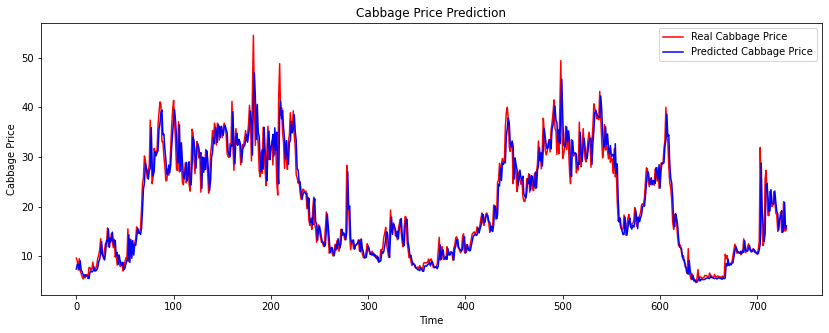

In [27]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(real_avg_price, color = 'red', label = 'Real Cabbage Price')
plt.plot(pre_price, color = 'blue', label = 'Predicted Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()